# Useful links

- [List of named colours for plotting time series](https://matplotlib.org/stable/gallery/color/named_colors.html)

# Import required packages

In [ ]:
import xarray as xr                                                  # handles gridded data
import numpy as np                                                   # numerical functions etc
import pandas as pd                                                  # handles tables of data (.csv, spreadsheets etc)
import re                                                            # allows manipulation of text strings

import matplotlib                                                    # plotting functions generally
import matplotlib.pyplot as plt                                      # specific plotting function we'll use a lot, so we'll give it a shorter name
from matplotlib.patches import Rectangle                             # specific plotting function with an annoyingly long name

import statsmodels.nonparametric.smoothers_lowess as sm_lowess       # nonparametric smoother

import cartopy                                                       # plotting geographical features
import regionmask                                                    # convert shapefile to binary 0,1 mask
import geopandas as gpd                                              # shapefiles

from geopy.geocoders import Nominatim                                # get lat & lon coordinates from a place name
from dateutil.relativedelta import relativedelta                     # calculate differences in times (needed to decode weird timestamps)

# filter out any annoying user warnings
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# you might get an error like 'ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed' - you can ignore this!

# Useful functions

In [ ]:
def wrap_lon(ds):
    
    # 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def decode_times(ts):
    
    # manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in ts.time.values]
    elif inc == "months":
        new_times = [np.datetime64(startdate + relativedelta(months = i)) for i in ts.time.values]
    elif inc == "days":
        new_times = [np.datetime64(startdate + relativedelta(days = i)) for i in ts.time.values]
    elif inc == "hours":
        new_times = [np.datetime64(startdate + relativedelta(hours = i)) for i in ts.time.values]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def get_latlon(city):
    
    # retrieve lat & lon for given place name
    location = Nominatim(user_agent="GetLoc").geocode(city)
    if location is None:
        return {"lon" : None, "lat" : None}
    else:
        return {"lon" : location.longitude, "lat" : location.latitude}
        
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def doy_axes(ax = None):

    # make nicer axis labels when you're plotting against day of year
    if ax is None: ax = plt.gca()
    
    # define axis labels for DOY plotting
    days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
    lineticks = [i+1 for i in range(366) if (days[i].day) == 1]
    labelticks = [i+1 for i in range(366) if (days[i].day) == 16]
    labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 16]

    # actually draw the axes & gridlines
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.1, lw = 1) for x in lineticks]
    ax.set_xlabel("")

# Load & plot time series data

In [ ]:
# first, load the time series
ts = xr.open_dataset("timeseries_pr-box.nc").tp

In [ ]:
# if you see an error message "Failed to decode variable 'time'", you'll need to decode the time steps manually like this:
# gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False))

## Smoothed seasonal cycle

In [ ]:
# first smooth the daily time series (mainly for precipitation - for temperatures you could use a shorter window, or even no smoothing, by setting sm_days = 1)
sm_days = 15
ts_sm = ts.rolling(time = sm_days, center = True).mean()

ts_clim = ts_sm.sel(time = slice("1990", "2020"))                   # select the time period to compute the climatology
mean_by_doy = ts_clim.groupby("time.dayofyear").mean()              # then average over each day of the year and plot

q05_by_doy = ts_clim.groupby("time.dayofyear").quantile(0.05)       # also get the central 90% of values for each day of the year
q95_by_doy = ts_clim.groupby("time.dayofyear").quantile(0.95)

In [ ]:
# plot the mean & quantiles
mean_by_doy.plot()
q05_by_doy.plot(color = "tab:blue", alpha = 0.5)   # lower bound of the central 95%
q95_by_doy.plot(color = "tab:blue", alpha = 0.5)   # upper bound of the central 95%

# add nicer axis labels and title
ax = plt.gca()                                            # give a name to the axis so that we can add more elements to it below
doy_axes()                                                # add nicer labels using user-defined function
ax.set_title("Seasonal cycle of precipitation")           # give a more meaningful title
ax.set_ylabel("Precipitation (mm/day)")                   # give proper units to y-axis

## Plot n-day average compared to previous years

Plot different accumulations to determine how long the extreme event lasted for

In [ ]:
# first, take the rolling average of the data (set ndays to 1 to see daily)
ndays = 30
ts_nday = ts.rolling(time = ndays, center = False).mean()

# plot just this year to start with
ts_y = ts_nday.sel(time = "2024")
plt.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", zorder = 9)       # 'zorder' sets the order the elements appear in the plot - higher zorders are on top of lower zorders

# add the climatological mean for reference
ts_nday_mean = ts_nday.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
plt.plot(ts_nday_mean.dayofyear, ts_nday_mean, color = "darkblue", alpha = 0.7, zorder = 5)

# loop over the other years & plot the annual time series
for y in np.unique(ts_nday.time.dt.year):
    ts_y = ts_nday.sel(time = str(y))
    plt.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3)
    
# add nicer axis labels and title
ax = plt.gca()                                            # give a name to the axis so that we can add more elements to it below
doy_axes()                                                # add nicer labels using user-defined function
ax.set_title(str(ndays)+"-day precipitation")           # give a more meaningful title
ax.set_ylabel("Precipitation (mm/day)")                   # give proper units to y-axis

# Creating an annual time series

## Annual maximum/minimum/mean
The easiest way to get an annual time series is to simply take the highest value per year  
Note: you could also do this on a gridded dataset

In [ ]:
# get the annual maximum (could also use min/mean in place of max)
ts_amax = ts_nday.resample(time = "YS-JAN").max()         # this starts the year in January but you could use eg. "YS-JUL" to start in July and and in June

## Annual maximum over selected months
If the event is unusual partly because of the time of year when it occurred, then you might want to look at only a specific month (or months)

In [ ]:
# first we choose just the months we're interested in - for example, we might only want to look at the wet season
ts_subset = ts_nday.sel(time = ts_nday.time.dt.month.isin([5,6,7,8,9]))

# then take the annual maximum like we did before
ts_smax = ts_subset.resample(time = "YS-JAN").max()

## Selecting a single calendar date from each year

To select a particular calendar date, we need to identify all days with a given month and day of the month

In [ ]:
ts_doy = ts.sel(time = ((ts.time.dt.month == 10) & (ts.time.dt.day == 31)))

# Looking at trends

## Rolling mean

We can put a simple running mean on top of the data to see what the trends look like over time

In [ ]:
# compute the 15-year running mean
ts_amax_sm = ts_amax.rolling(time = 15, center = True).mean()

In [ ]:
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_sm.plot(color = "darkblue", lw = 2)


## Nonparametric smoothed trend

This is a local nonparametric smoother called a lowess smoother - basically it's a bit like a rolling average but smoother, and you don't have gaps at either end of the series  

In [ ]:
# get the smoothed values: we want to smooth the values over time
ts_amax_np = sm_lowess.lowess(ts_amax, ts_amax.time.dt.year, frac = 2/3)    # 'frac' determines the fraction of the data used to smooth each point - smaller frac means wigglier data (default is 2/3)

# turn the smoothed values back into a dataarray so they're easier to plot
ts_amax_np = xr.DataArray(data = ts_amax_np[:,1], dims = ["time"], name = "z", coords = dict(ts_amax.coords))

In [ ]:
# we can plot both to compare them, and add labels
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_sm.plot(color = "darkblue", label = "Rolling mean")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Smoothed")

plt.legend()

## Linear trend over time
It's always useful to compare the fitted trend to the nonparametric smoother, to check if the observed & fitted trends are similar

In [ ]:
# fit a linear trend through the data
linear_coeffs = ts_amax.polyfit("time", deg = 1).polyfit_coefficients

# we can use the estimated coefficients to get the expected temperature in each year, and plot them
fitted_values = xr.polyval(ts_amax.time, linear_coeffs)

ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2, label = "Linear trend over time")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Smoothed")

plt.legend()

### Check the fit through a shorter time period
If the trend changes over time, it might be useful to fit a line to a shorter time period, to see how different they are  
If the most recent value is particularly extreme, it's also important to check that the trend doesn't change too much when we include/exclude it

In [ ]:
# fit linear trend without 2024 to check how much of a difference this very high value makes
ts_excl2024 = ts_amax.sel(time = slice(None, "2023"))
lc_excl2024 = ts_excl2024.polyfit("time", deg = 1).polyfit_coefficients
fv_excl2024 = xr.polyval(ts_excl2024.time, lc_excl2024)

ts_amax.plot(drawstyle = "steps-mid")
fitted_values.plot(color = "k", lw = 2, alpha = 0.7, label = "Linear trend over time")
fv_excl2024.plot(color = "darkred", lw = 2, label = "Linear trend excluding 2024")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Nonparametric smoothesmoothed")

plt.legend()

## Linear trend dependent on GMST

Unless you're looking at a fairly short period, it's unlikely that any trend will be linear over time (that implies that it changes at a constant rate each year)  
Instead, we can look at how our time series changes as the global mean surface temperature changes

The latest 4-year smoothed GMST time series can be downloaded from https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.nc

In [ ]:
# first, load the GMST time series and select just the period we're interested in
# annual data from the Climate Explorer has weirdly formatted times so we need to decode them manually
gmst = decode_times(xr.open_dataset("igiss_al_gl_a_4yrlo.nc", decode_times = False)).Ta

# select the same years that are in our annual time series
gmst = gmst.sel(time = gmst.time.dt.year.isin(ts_amax.time.dt.year))

# fit a linear trend to GMST by replacing time with gmst values
gmst_coeffs = ts_amax.assign_coords(time = gmst.values).polyfit("time", deg = 1).polyfit_coefficients

# use the estimated coefficients to get the expected temperature in each year
gmst_fitted = xr.polyval(gmst, gmst_coeffs)

print("Change per 1deg GMST increase: ", gmst_coeffs.sel(degree = 1).round(2).values)

In [ ]:
# plot the fitted trend against the obs to see if it makes sense (also useful to compare to the nonparametric smoother to see if they look similar)
ts_amax.plot(drawstyle = "steps-mid")
ts_amax_np.plot(color = "darkgreen", lw = 2, label = "Nonparametric smoother")
gmst_fitted.plot(color = "k", lw = 2, label = "GMST trend")

plt.legend()

# Other interesting questions

## Was this the wettest day on record?

In [ ]:
# we can sort the daily values into ascending order and see when the most extreme events occurred
ts_sorted = ts.sortby(ts, ascending = False)

# then we can look at the times when the 10 wettest events occurred
# convert to a dataframe to see the times & values together in a table
ts_sorted[:10].to_dataframe()

## How many times have we exceeded a particular threshold, and when?

In [ ]:
# select just those days that exceed some threshold of interest
wet_days = ts.where(ts >= 10).dropna("time", how = "any")

In [ ]:
# we can plot how much rain fell on the wettest days
wet_days.plot(ls = "", marker = ".")

In [ ]:
# we can also look at counts of wet days each year
n_wetdays = wet_days.resample(time = "YS-JAN").count()    

# to make a bar plot we have to give both the x coordinate (in this case, the year) and the height of the bar
plt.bar(x = n_wetdays.time.dt.year, height = n_wetdays)

# Save an annual time series for uploade to the climate explorer

If you want to use the Climate Explorer's tools to analyse an annual time series, you can upload your own data, but it needs to be in a particular format.

- the first line should start '# year' (and then a variable name)
- each row should have a year and one value, with a space in between
- it has to be years, dates won't work

In [ ]:
# this line will save your data in the correct format
ts_amax.assign_coords(time = ts_amax.time.dt.year).rename(time = "#year").to_dataframe().to_csv("annual-time-series-for-climexp.csv", sep = " ")

Now find the file in the file explorer on the left and 'open with editor', select all & copy

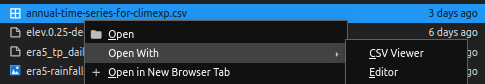

Now sign in to the climate explorer, go to 'view, upload your time series' in the right-hand menu  
Delete the text in the big box in the 'upload text data' section, and paste your data in instead  
Give it a meaningful name in the box above so you can find it later  
Press 'upload' - now you can work with your time series as if you'd created it directly in the climate explorer